In [1]:
import sys
sys.path.append('d:\\dev\\mt5-python')

import pandas as pd
import numpy as np
from datetime import datetime, time, timedelta
from modules import TradingStrategy
from modules import TriangleStrategy

In [2]:
import matplotlib.pyplot as plt

def plot_df(df, buy_entries=[], buy_exits=[], sell_entries=[], sell_exits=[]):
    plt.figure(figsize=(16,4))
    
    # Convert DataFrame columns and indices to numpy arrays for faster operations
    closes = df['close'].values
    indices = df.index.values
    
    # Plotting the close prices
    plt.plot(indices, closes, label='Close', alpha=0.7)
    
    # Plotting buy and sell points
    plt.scatter(indices[buy_entries], closes[buy_entries], marker='^', color='g', label='Buy Entry', alpha=0.7)
    plt.scatter(indices[buy_exits], closes[buy_exits], marker='v', color='darkgreen', label='Buy Exit', alpha=0.7)
    plt.scatter(indices[sell_entries], closes[sell_entries], marker='v', color='r', label='Sell Entry', alpha=0.7)
    plt.scatter(indices[sell_exits], closes[sell_exits], marker='^', color='darkred', label='Sell Exit', alpha=0.7)
    
    plt.title('Close Price Over Time')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

In [3]:
def plot_df_with_reversal(df, buy_entries=[], buy_exits=[], sell_entries=[], sell_exits=[], reversal_prices=[]):
    plt.figure(figsize=(20,6))
    
    # Convert DataFrame columns and indices to numpy arrays for faster operations
    closes = df['close'].values
    indices = df.index.values
    
    # Concatenate buy and sell entries for plotting reversal prices
    combined_entries = buy_entries + sell_entries
    
    # Plotting the close prices
    plt.plot(indices, closes, label='Close', alpha=0.7)
    
    # Plotting buy and sell points
    plt.scatter(indices[buy_entries], closes[buy_entries], marker='^', color='g', label='Buy Entry', alpha=0.7, s=100)
    plt.scatter(indices[buy_exits], closes[buy_exits], marker='v', color='darkgreen', label='Buy Exit', alpha=0.7, s=100)
    plt.scatter(indices[sell_entries], closes[sell_entries], marker='v', color='r', label='Sell Entry', alpha=0.7, s=100)
    plt.scatter(indices[sell_exits], closes[sell_exits], marker='^', color='darkred', label='Sell Exit', alpha=0.7, s=100)
    
    # Plotting reversal prices
    plt.scatter(indices[combined_entries], reversal_prices, marker='o', color='black', label='Reversal prices', alpha=0.7, s=100)
    
    plt.title('Close Price Over Time')
    plt.xlabel('Time')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# The function has been updated to plot reversal prices using combined buy and sell entry indices.


In [4]:
from bokeh.plotting import figure, show, output_notebook

def plot_df_bokeh(df, buy_entries=[], buy_exits=[], sell_entries=[], sell_exits=[], trendline_starts=[], trendline_ends=[]):
    output_notebook()
    
    # Create a Bokeh figure
    p = figure(width=1200, height=600, x_axis_type="datetime", title="Close Price Over Time", background_fill_color="#1a1a1a", border_fill_color="#1a1a1a", output_backend="webgl")
    
    # Adjusting width for candlesticks
    w = (df.index[1] - df.index[0]) * 2.0

    # Adding the candlestick chart with adjusted colors
    inc = df.close > df.open
    dec = df.open > df.close
    p.segment(df.index[inc], df.high[inc], df.index[inc], df.low[inc], color="#26A69A", line_width=0.2)
    p.segment(df.index[dec], df.high[dec], df.index[dec], df.low[dec], color="#EF5350", line_width=0.2)
    p.vbar(df.index[inc], w, df.open[inc], df.close[inc], fill_color="#26A69A", line_color="#26A69A")
    p.vbar(df.index[dec], w, df.open[dec], df.close[dec], fill_color="#EF5350", line_color="#EF5350")
    
    # Plotting buy and sell points with simplified markers
    p.triangle(df.index[buy_entries], df['close'].iloc[buy_entries], size=10, color="green", legend_label="Buy Entry")
    p.inverted_triangle(df.index[buy_exits], df['close'].iloc[buy_exits], size=10, color="darkgreen", legend_label="Buy Exit")
    p.inverted_triangle(df.index[sell_entries], df['close'].iloc[sell_entries], size=10, color="red", legend_label="Sell Entry")
    p.triangle(df.index[sell_exits], df['close'].iloc[sell_exits], size=10, color="darkred", legend_label="Sell Exit")
    
    # Plotting trendlines
    for start, end in zip(trendline_starts, trendline_ends):
        color = "yellow" if df['close'].iloc[start] < df['close'].iloc[end] else "blue" # Yellow for uptrend, blue for downtrend
        p.line([df.index[start], df.index[end]], [df['close'].iloc[start], df['close'].iloc[end]], color=color, line_width=1.5, legend_label="Trendline")

    # Adjusting aesthetics for dark mode
    p.grid.grid_line_alpha = 0.3
    p.grid.grid_line_color = "gray"
    p.xaxis.axis_label = 'Time'
    p.yaxis.axis_label = 'Price'
    p.legend.background_fill_alpha = 0.4
    p.legend.background_fill_color = "#333333"
    p.legend.label_text_color = "white"
    p.xaxis.axis_label_text_color = "white"
    p.yaxis.axis_label_text_color = "white"
    p.xaxis.major_label_text_color = "white"
    p.yaxis.major_label_text_color = "white"
    
    show(p)


In [5]:
def filter_dataframe_by_date(df, start_date=None, end_date=None):
    datetime_column_name = 'time'
    if start_date:
        df = df[df[datetime_column_name] >= start_date]
    if end_date:
        df = df[df[datetime_column_name] <= end_date]
    return df

In [6]:
def summarize_trade_results(trade_results, strategy_name):
    total_win = sum(x for x in trade_results['pips'] if x > 0)
    total_loss = -sum(x for x in trade_results['pips'] if x < 0)
    profit_factor = total_win / total_loss if total_loss != 0 else 0

    long_win_rate = sum(1 for x in trade_results['long_pips'] if x > 0) / len(trade_results['long_pips']) if trade_results['long_pips'] else 0
    short_win_rate = sum(1 for x in trade_results['short_pips'] if x > 0) / len(trade_results['short_pips']) if trade_results['short_pips'] else 0

    # Print and log the statistics
    lines = [
        f"Strategy: {strategy_name}",
        f"Total trade Num: {len(trade_results['long_pips']) + len(trade_results['short_pips'])}",
        f"Total pips: {format(sum(trade_results['pips']), ',.2f')}",
        f"Profit Factor: {profit_factor:.2f}",
        f"Long Trade Num: {len(trade_results['long_pips'])}",
        f"Long Win Rate: {long_win_rate:.2f}",
        f"Short Trade Num: {len(trade_results['short_pips'])}",
        f"Short Win Rate: {short_win_rate:.2f}\n"
    ]
    
    for line in lines:
        print(line)
        # logging.info(line)

    # Create cumulative return series
    cumulative_pips = np.cumsum(trade_results['pips'])
    cumulative_long_pips = np.cumsum(trade_results['long_pips'])
    cumulative_short_pips = np.cumsum(trade_results['short_pips'])

    # Plot the results
    plt.figure(figsize=(8,4))
    plt.plot(cumulative_pips, label='Total Pips')
    plt.title("Cumulative Total Pips")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Pips")
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(8,4))
    plt.plot(cumulative_long_pips, label='Long Pips', color='blue')
    plt.plot(cumulative_short_pips, label='Short Pips', color='red')
    plt.title("Cumulative Long and Short Pips")
    plt.xlabel("Trade")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
def filter_dataframe_by_date(df, start_date=None, end_date=None):
    datetime_column_name = 'time'
    if start_date:
        df = df[df[datetime_column_name] >= start_date]
    if end_date:
        df = df[df[datetime_column_name] <= end_date]
    return df

In [8]:
# Initialize portfolio state
def init_portfolio():
    return {
        'position': None,  # "long" or "short"
        'entry_price': None,
        'entry_point': 0,
        'trailing_stop': 0,
        'take_profit': None,
        'stop_loss': None,
        'profit': 0
    }

def trade_logic(df, trade_conditions_func):
    df = df.reset_index(drop=True)

    closes = df['close'].values
    spreads = df['spread'].values

    trade_results = {
        'pips': [],
        'long_pips': [],
        'short_pips': [],
        'buy_entries': [],
        'buy_exits': [],
        'sell_entries': [],
        'sell_exits': []
    }

    portfolio = init_portfolio()

    for i in range(0, len(df)):
        pips = 0

        action = trade_conditions_func(df, i, portfolio, closes, spreads)

        if portfolio['position'] is not None:
            if action == 'exit_long':
                trade_results['pips'].append(portfolio['pips'])
                trade_results['long_pips'].append(portfolio['pips'])
                trade_results['buy_exits'].append(i)
                portfolio = init_portfolio()

            if action == 'exit_short':
                trade_results['pips'].append(portfolio['pips'])
                trade_results['short_pips'].append(portfolio['pips'])
                trade_results['sell_exits'].append(i)
                portfolio = init_portfolio()

            else:
                trade_results['pips'].append(pips)
        
        elif action == 'entry_long':
            trade_results['pips'].append(pips)
            trade_results['buy_entries'].append(i)
            portfolio['position'] = 'long'

        elif action == 'entry_short':
            trade_results['pips'].append(pips)
            trade_results['sell_entries'].append(i)
            portfolio['position'] = 'short'

        else:
            trade_results['pips'].append(pips)

    return trade_results

Strategy: trend reversal
Total trade Num: 430
Total pips: 844.92
Profit Factor: 1.27
Long Trade Num: 97
Long Win Rate: 0.71
Short Trade Num: 333
Short Win Rate: 0.75



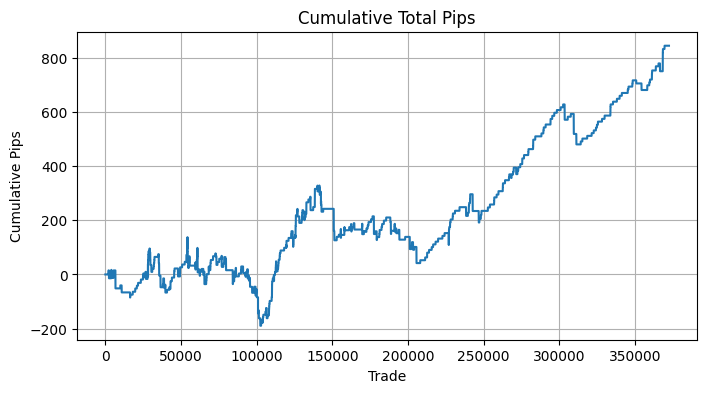

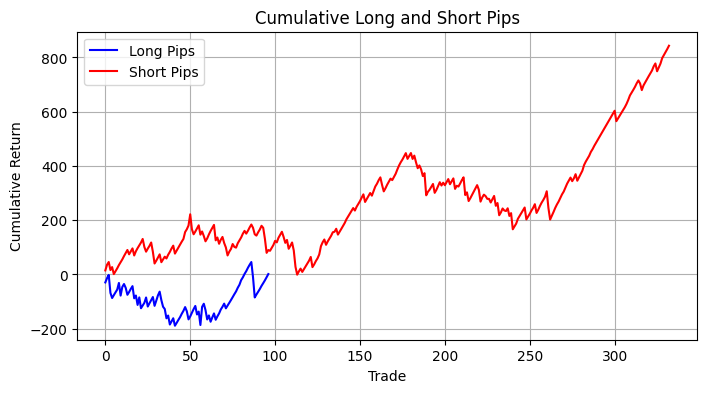

In [9]:
# Backtest

# 1pips = 0.01 point
settings_triangle = { 
    'risk_reward_ratio': 1.3,
    'take_profit_pips': 0.15,
    'stop_loss_pips': 0.10,
    'base_spread_pips': 0.03,
    'df_sliced_period': 200,
    'distance': 15,
    'pivot_count': 3,
    'horizontal_distance': 60,
    'horizontal_threshold': 3,
    'entry_horizontal_distance': 0.01, # 0.01 ~ 0.03 ?
}

# 1pips = 0.0001 point
# settings = {
#     'risk_reward_ratio': 1.2,
#     'take_profit_pips': 0.0010,
#     'stop_loss_pips': 0.0015,
#     'base_spread_pips': 0.0005,
#     'df_sliced_period': 200,
#     'distance': 15,
#     'pivot_count': 4,
#     'horizontal_distance': 10,
#     'horizontal_threshold': 3,
#     'entry_horizontal_distance': 0.0002, # 0.0001 ~ 0.0003 ?
# }
# settings=None

settings_reversal_eurusd = { 
    'symbol': 'EURUSD',
    'risk_reward_ratio': 1.0, # 1.0
    'stop_loss_pips': 0.0010, # 0.0010
    'base_spread_pips': 0.0005, # 0.0005
    'df_sliced_period': 200, # 300~500
    'distance': 3, # 5~7
    'candle_size_pips': 0.0005
}

# spread 平均値: 約18.34  中央値: 9.0
settings_reversal_gbpjpy = { 
    'symbol': 'GBPJPY',
    'risk_reward_ratio': 1.0, # 1.0
    'stop_loss_pips': 0.20, # 0.10
    'base_spread_pips': 0.10, # 0.01
    'df_sliced_period': 500, # 300~500
    'distance': 7, # 5~7
    'candle_size_pips': 0.05 # 0.04~0.05
}

settings_reversal_usdjpy = { 
    'symbol': 'USDJPY',                 
    'risk_reward_ratio': 1.0, # 1.0
    'stop_loss_pips': 0.10, # 0.10
    'base_spread_pips': 0.03, # 0.03
    'df_sliced_period': 500, # 300~500
    'distance': 7, # 5~7
    'candle_size_pips': 0.05, # 0.04~0.05
}

params = settings_reversal_eurusd

file_name = f"../csv/{params['symbol']}_1_20220801_to_20230801.csv"
symbol = params['symbol']
df = pd.read_csv(file_name)

if __name__ == '__main__':
    st_triangle = TriangleStrategy(symbol=symbol, allow_long=True, allow_short=True, params=settings_triangle)
    st_reversal = TradingStrategy(params=params)

    # Filter data by date if required
    start_date = None
    end_date = None

    # 2022-10-01 ~ 2022-11-01　が弱い、2023-08-01~2023-09-15 エントリしない
    start_date = "2022-08-01"
    end_date = "2022-12-01"
    # df = filter_dataframe_by_date(df, start_date, end_date)

    trade_conditions = [
        # (st_triangle.trade_conditions_func, "trend line trade"),
        (st_reversal.trade_logic_trend_reversal, "trend reversal")
    ]

    # Execute the trade logic
    for trade_condition, description in trade_conditions:
        result = trade_logic(df, trade_condition)

        # plot_df(df, 
        #     result['buy_entries'], 
        #     result['buy_exits'], 
        #     result['sell_entries'], 
        #     result['sell_exits'],
        # )

        # plot_df_bokeh(df, 
        #     result['buy_entries'], 
        #     result['buy_exits'], 
        #     result['sell_entries'], 
        #     result['sell_exits'], 
        #     result['trendline_start_idx'], 
        #     result['trendline_end_idx']
        # )

        summarize_trade_results(result, description)


In [10]:
result = st_reversal.get_trade_results()
df_trade_results = pd.DataFrame(result)
display(df_trade_results)

,index,action,entry_price,exit_price,reversal_price,take_profit_price,stop_loss_price,gained_pips
0,1984,entry_short,1.02428,0.00000,1.02669,1.02328,1.02844,0.0000
1,2042,exit_short,1.02428,1.02278,1.02669,1.02328,1.02844,15.0005
2,2092,entry_long,1.02435,0.00000,1.02299,1.02535,1.02159,0.0000
3,2328,exit_long,1.02435,1.02143,1.02299,1.02535,1.02159,-29.2005
4,3829,entry_short,1.01727,0.00000,1.01944,1.01627,1.02203,0.0000
...,...,...,...,...,...,...,...,...
855,368237,exit_short,1.10156,1.10049,1.11448,1.10056,1.10564,10.7005
856,368242,entry_short,1.10044,0.00000,1.11448,1.09944,1.10276,0.0000
857,368266,exit_short,1.10044,1.09925,1.11448,1.09944,1.10276,11.9005
858,369116,entry_short,1.09597,0.00000,1.10272,1.09497,1.10102,0.0000


In [11]:
# Total statistics
total_win = df_trade_results[df_trade_results['gained_pips'] > 0]['gained_pips'].sum()
total_loss = abs(df_trade_results[df_trade_results['gained_pips'] < 0]['gained_pips'].sum())
profit_factor = total_win / total_loss if total_loss != 0 else 0

short_trades = df_trade_results[df_trade_results['action'] == 'exit_short']
long_trades = df_trade_results[df_trade_results['action'] == 'exit_long']
short_win_rate = len(short_trades[short_trades['gained_pips'] > 0]) / len(short_trades) if len(short_trades) != 0 else 0
long_win_rate = len(long_trades[long_trades['gained_pips'] > 0]) / len(long_trades) if len(long_trades) != 0 else 0
total_trades = len(short_trades) + len(long_trades)

# Calculate the cumulative pips and maximum drawdown
df_trade_results['cumulative_pips'] = df_trade_results['gained_pips'].cumsum()
df_trade_results['running_max'] = df_trade_results['cumulative_pips'].cummax()
df_trade_results['drawdown'] = df_trade_results['running_max'] - df_trade_results['cumulative_pips']
max_drawdown = df_trade_results['drawdown'].max()
max_drawdown_percentage = (max_drawdown / df_trade_results['running_max'].max()) * 100 if df_trade_results['running_max'].max() != 0 else 0

# Print the statistics
lines = [
    f"Total trade: {total_trades}",
    f"Total gained pips: {df_trade_results['gained_pips'].sum():,.2f}",
    f"Profit Factor: {profit_factor:.2f}",
    f"Long Trade: {len(long_trades)}",
    f"Long Win: {long_win_rate * 100:.2f} %",
    f"Short Trade: {len(short_trades)}",
    f"Short Win: {short_win_rate * 100:.2f} %",
    f"Max Drawdown: {max_drawdown:.2f} ({max_drawdown_percentage:.2f} %)\n"
]

for line in lines:
    print(line)

Total trade: 430
Total gained pips: 844.92
Profit Factor: 1.27
Long Trade: 97
Long Win: 71.13 %
Short Trade: 333
Short Win: 74.77 %
Max Drawdown: 327.08 (38.71 %)



In [12]:
max_value = df_trade_results['gained_pips'].max()
print(f'max pips: {max_value}')

min_value = df_trade_results['gained_pips'].min()
print(f'min pips: {min_value}')

max pips: 66.99949999999929
min pips: -81.59949999999945


In [13]:
current_time = datetime.now().strftime('%Y%m%d%H%M%S')
filename = f"trade_result_{symbol}_{current_time}.csv"
folder_path = "../csv"
full_path = f"{folder_path}/{filename}"
df_trade_results.to_csv(full_path, index=False)